In [12]:
from habitat.tasks.nav.nav import (
    NavigationEpisode,
    NavigationGoal,
    NavigationTask,
)

In [13]:
dir(NavigationGoal)

['__annotations__',
 '__attrs_attrs__',
 '__attrs_props__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__']

In [14]:
import gzip
import json

# ===== 修改为你的 train.json.gz 路径 =====
path = "/home/Disk/sound-space/data/datasets/semantic_audionav/mp3d/v1/test/content/split_2.json.gz"

with gzip.open(path, "rt", encoding="utf-8") as f:
    text = f.read()

print("File loaded.")
print("Text length:", len(text))


File loaded.
Text length: 70650


In [15]:
text

'{"episodes": [{"episode_id": "2845", "scene_id": "yqstnuAEVhm/yqstnuAEVhm.glb", "start_position": [0.632884, -0.004817000000000071, -10.618986], "start_rotation": [0.0, 0.7071067811865475, 0.0, 0.7071067811865476], "info": {"geodesic_distance": 4.0, "num_action": 7}, "goals": [{"position": [0.632884, -0.015352000000000032, -12.618986], "radius": 1e-05, "object_id": 602, "object_name": null, "object_category": null, "room_id": null, "room_name": null, "view_points": [[0.632884, -0.015352000000000032, -12.618986], [1.632884, -0.015352000000000032, -13.618986], [2.632884, -0.015352000000000032, -13.618986]]}], "start_room": null, "shortest_paths": null, "object_category": "tv_monitor", "sound_id": "test/tv_monitor.wav", "offset": "0", "duration": "18"}, {"episode_id": "145", "scene_id": "yqstnuAEVhm/yqstnuAEVhm.glb", "start_position": [-0.367116, -0.004817000000000071, -11.618986], "start_rotation": [0.0, 1.0, 0.0, 6.123233995736766e-17], "info": {"geodesic_distance": 8.0, "num_action": 

In [16]:
train_gz_path = "/home/Disk/sound-space/data/datasets/semantic_audionav/mp3d/v1/test/content/split_0.json.gz"   # TODO: 改成你的实际路径

fmt, data, episodes = read_train_json_gz(path)

print("Format:", fmt)
print("Total episodes:", len(episodes))

# 看看 episode 有哪些常见 key（取前 5 个统计一下）
from collections import Counter

key_counter = Counter()
for ep in episodes[:500]:  # 前500个够看了
    if isinstance(ep, dict):
        key_counter.update(ep.keys())

print("\nTop keys:")
for k, c in key_counter.most_common(20):
    print(f"  {k}: {c}")


NameError: name 'read_train_json_gz' is not defined

In [ ]:
import os
from collections import Counter

def count_scenes(root_dir: str):
    scene_names = []
    for name in os.listdir(root_dir):
        path = os.path.join(root_dir, name)
        if not os.path.isdir(path):
            continue

        # 只取第一个 "_" 前面的部分作为场景名
        if "_" in name:
            scene = name.split("_", 1)[0]
            scene_names.append(scene)

    unique_scenes = sorted(set(scene_names))
    counts = Counter(scene_names)

    print(f"Root: {root_dir}")
    print(f"Total subfolders matched: {len(scene_names)}")
    print(f"Unique scenes: {len(unique_scenes)}")

    # 如果你还想看每个 scene 出现了多少次（可选）
    print("\nTop scenes by occurrences:")
    for scene, c in counts.most_common(20):
        print(f"{scene}: {c}")

    return len(unique_scenes), counts

if __name__ == "__main__":
    root_dir = "/home/Disk/sound-space/ssl_data_semantic/train"  # TODO: 改成你的目录
    n_unique, counts = count_scenes(root_dir)


Root: /home/Disk/sound-space/ssl_data_semantic/train
Total subfolders matched: 50991
Unique scenes: 56

Top scenes by occurrences:
EDJbREhghzL: 1989
1LXtFkjw3qL: 1596
JeFG25nYj2p: 1507
V2XKFyX4ASd: 1420
qoiz87JEwZ2: 1372
b8cTxDM8gDG: 1341
VFuaQ6m2Qom: 1339
aayBHfsNo7d: 1303
5q7pvUzZiYa: 1286
ZMojNkEp431: 1237
7y3sRwLe3Va: 1201
e9zR4mvMWw7: 1170
uNb9QFRL6hY: 1148
jh4fc5c5qoQ: 1142
S9hNv5qa7GM: 1131
mJXqzFtmKg4: 1130
sKLMLpTHeUy: 1116
rPc6DW4iMge: 1115
ac26ZMwG7aT: 1095
8WUmhLawc2A: 1050


In [26]:
#!/usr/bin/env python3

# Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
import cv2
import os
import time
import logging
from collections import deque
from typing import Dict, List
# import laion_clap
import json
import random
import sys
sys.path.append("/media/kemove/data/av_nav/network/audionet")
sys.path.append("/media/kemove/data/av_nav/utlis")
sys.path.append("/media/kemove/data/av_nav/network/visual_infer")
sys.path.append("/media/kemove/data/av_nav/network/av_map/")
from clap_utils import *
from yolo_heatmap import yolo_infer, mask_depth_to_binary_topdown, StreamingVisualMapFusion
from prob_update import GlobalSoundMapRefiner,quaternion_to_heading_y,source_in_agent_frame,localmap_argmax_world
from prob_update_doa import StreamingSourceMapFusion, align_for_occ
from ssl_net_infer import SSLNet,SSLNet_DOA,SSLNet_depth_DOA
# from ss_baselines.savi.pretraining_compare.audiogoal_predictor import AudioGoalPredictor_infer
from ss_baselines.savi.pretraining_ours.audiogoal_predictor import AudioGoalPredictor_infer
from ultralytics import YOLO
import numpy as np
import torch
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm
from numpy.linalg import norm

from habitat import Config, logger
from ss_baselines.common.base_trainer import BaseRLTrainer
from ss_baselines.common.baseline_registry import baseline_registry
from ss_baselines.common.env_utils import construct_envs
from ss_baselines.common.environments import get_env_class
from ss_baselines.common.rollout_storage import RolloutStorage
from ss_baselines.common.tensorboard_utils import TensorboardWriter
from ss_baselines.common.utils import (
    batch_obs,
    generate_video,
    linear_decay,
    exponential_decay,
    plot_top_down_map,
    resize_observation
)
from ss_baselines.av_wan.ppo import AudioNavBaselinePolicy
from ss_baselines.av_wan.ppo import PPO




@baseline_registry.register_trainer(name="AVWanTrainer")
class PPOTrainer(BaseRLTrainer):
    r"""Trainer class for PPO algorithm
    Paper: https://arxiv.org/abs/1707.06347.
    """
    supported_tasks = ["Nav-v0"]

    def __init__(self, config=None):
        super().__init__(config)
        self.actor_critic = None
        self.agent = None
        self.envs = None


    def _eval_checkpoint(
            self,
            checkpoint_path: str,
            writer: TensorboardWriter,
            checkpoint_index: int = 0
    ) -> Dict:
        r"""Evaluates a single checkpoint.

        Args:
            checkpoint_path: path of checkpoint
            writer: tensorboard writer object for logging to tensorboard
            checkpoint_index: index of cur checkpoint for logging

        Returns:
            None
        """
        random.seed(self.config.SEED)
        np.random.seed(self.config.SEED)
        torch.manual_seed(self.config.SEED)

        # Map location CPU is almost always better than mapping to a CUDA device.
        ckpt_dict = self.load_checkpoint(checkpoint_path, map_location="cpu")


        if self.config.EVAL.USE_CKPT_CONFIG:
            config = self._setup_eval_config(ckpt_dict["config"])
        else:
            config = self.config.clone()

        ppo_cfg = config.RL.PPO

        config.defrost()
        config.TASK_CONFIG.DATASET.SPLIT = config.EVAL.SPLIT
        if self.config.DISPLAY_RESOLUTION != config.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.WIDTH:
            model_resolution = config.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.WIDTH
            config.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.WIDTH = config.TASK_CONFIG.SIMULATOR.RGB_SENSOR.HEIGHT = \
                config.TASK_CONFIG.SIMULATOR.RGB_SENSOR.WIDTH = config.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HEIGHT = \
                self.config.DISPLAY_RESOLUTION
        else:
            model_resolution = self.config.DISPLAY_RESOLUTION
        config.freeze()
        config.defrost()
        config.TASK_CONFIG.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
        config.TASK_CONFIG.TASK.MEASUREMENTS.append("COLLISIONS")
        config.TASK_CONFIG.TASK.SENSORS.append("AUDIOGOAL_SENSOR")
        config.freeze()

        logger.info(f"env config: {config}")
        self.envs = construct_envs(
            config, get_env_class(config.ENV_NAME), auto_reset_done=False
        )
        habitat_env = self.envs.workers[0]._env.habitat_env
        sim = habitat_env.sim


 

here


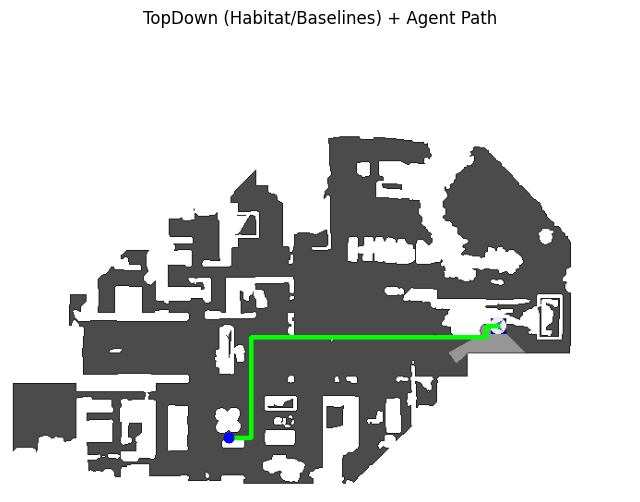

In [34]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

from ss_baselines.common.utils import plot_top_down_map

NPZ_DIR = "/home/Disk/yyz/sound-spaces/debug_npz/fzynW3qQPVF_ep5103"

# 0.0, 1.0, ..., 33.0 排序
files = sorted(
    glob.glob(os.path.join(NPZ_DIR, "*.npz")),
    key=lambda p: float(os.path.basename(p).replace(".npz",""))
)

def npz_to_info(d):
    xy = d["agent_map_coord"]
    return {
        "top_down_map": {
            "map": d["map"],
            "fog_of_war_mask": d["fog_of_war_mask"],
            "agent_map_coord": (int(xy[0]), int(xy[1])),
            "agent_angle": float(d["agent_angle"]),
        }
    }

# === 1) 用第一帧生成官方 topdown 底图 ===
d0 = np.load(files[0])
info0 = npz_to_info(d0)
img_rgb = plot_top_down_map(info0, dataset="mp3d")   # RGB uint8

# === 2) 读整条轨迹（agent_map_coord） ===
path = []
for f in files:
    d = np.load(f)
    xy = d["agent_map_coord"]
    path.append((int(xy[0]), int(xy[1])))
path = np.array(path, dtype=np.int32)  # [T,2]

# === 3) 在官方底图上画轨迹（OpenCV画线） ===
img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

# 轨迹线（红）
for i in range(1, len(path)):
    r1, c1 = path[i-1]
    r2, c2 = path[i]
    cv2.line(img_bgr, (c1, r1), (c2, r2), (0,255,0), 4)

# 起点（绿）终点（蓝）
r0, c0 = path[0]
r1, c1 = path[-1]
# cv2.circle(img_bgr, (c0, r0), 6, (0, 255, 0), -1)   # start
cv2.circle(img_bgr, (c1, r1), 6, (255, 0, 0), -1)   # end

# === 4) 显示 ===
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("TopDown (Habitat/Baselines) + Agent Path")
plt.show()


In [36]:
path

array([[319, 529],
       [319, 516],
       [319, 516],
       [331, 516],
       [331, 516],
       [331, 504],
       [331, 492],
       [331, 480],
       [331, 468],
       [331, 456],
       [331, 443],
       [331, 431],
       [331, 419],
       [331, 407],
       [331, 395],
       [331, 383],
       [331, 370],
       [331, 358],
       [331, 346],
       [331, 334],
       [331, 322],
       [331, 310],
       [331, 297],
       [331, 285],
       [331, 273],
       [331, 261],
       [331, 261],
       [343, 261],
       [355, 261],
       [367, 261],
       [379, 261],
       [392, 261],
       [404, 261],
       [416, 261],
       [428, 261],
       [440, 261],
       [440, 261],
       [440, 249],
       [440, 237],
       [440, 237]], dtype=int32)

In [8]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

from ss_baselines.common.utils import plot_top_down_map

A_DIR = "/home/Disk/yyz/sound-spaces/vis/debug_npz/fzynW3qQPVF_ep5654"  # 改成你的A
B_DIR = "/home/Disk/yyz/sound-spaces/vis/debug_npz_ours/fzynW3qQPVF_ep5654"  # 改成你的B


In [9]:
def sorted_npz_files(d):
    files = glob.glob(os.path.join(d, "*.npz"))
    assert len(files) > 0, f"No npz in {d}"
    return sorted(files, key=lambda p: float(os.path.basename(p).replace(".npz","")))

filesA = sorted_npz_files(A_DIR)
filesB = sorted_npz_files(B_DIR)

print("A steps:", len(filesA), "first/last:", os.path.basename(filesA[0]), os.path.basename(filesA[-1]))
print("B steps:", len(filesB), "first/last:", os.path.basename(filesB[0]), os.path.basename(filesB[-1]))


A steps: 24 first/last: 0.0.npz 23.0.npz
B steps: 34 first/last: 0.0.npz 36.0.npz


In [10]:
def world_to_grid_rc(world_xz, bounds, H, W, flip_z=False):
    """world_xz: [N,2] (x,z) -> rc: [N,2] (row,col)"""
    (minx, _, minz), (maxx, _, maxz) = bounds
    x = world_xz[:, 0]
    z = world_xz[:, 1]

    # col from x
    c = (x - minx) / (maxx - minx + 1e-9) * (W - 1)

    # row from z (optionally flipped)
    if flip_z:
        r = (maxz - z) / (maxz - minz + 1e-9) * (H - 1)
    else:
        r = (z - minz) / (maxz - minz + 1e-9) * (H - 1)

    rc = np.stack([r, c], axis=1)
    return rc

def pick_best_flip(worldA, rcA, bounds, H, W):
    """用A中已有 agent_map_coord 作为参照，自动选择 flip_z True/False"""
    pred0 = world_to_grid_rc(worldA, bounds, H, W, flip_z=False)
    pred1 = world_to_grid_rc(worldA, bounds, H, W, flip_z=True)
    e0 = np.mean(np.linalg.norm(pred0 - rcA, axis=1))
    e1 = np.mean(np.linalg.norm(pred1 - rcA, axis=1))
    flip = (e1 < e0)
    print(f"Mean pixel error no-flip={e0:.3f}, flip_z={e1:.3f}  ->  use flip_z={flip}")
    return flip


In [11]:
def load_world_and_rc(files):
    world = []
    rc = []
    for f in files:
        d = np.load(f)
        world.append(d["agent_pos"].astype(np.float32))                 # (x,z)
        rc.append(d["agent_map_coord"].astype(np.float32))             # (row,col)
    return np.stack(world), np.stack(rc)

# A: 有 world + rc，用来确定 flip_z
worldA, rcA = load_world_and_rc(filesA)

# 从 A 的第一帧拿 bounds/map_shape
d0 = np.load(filesA[0])
bounds = d0["bounds"].astype(np.float32)
H, W = map(int, d0["map_shape"])

# 自动选择 z 是否翻转
flip_z = pick_best_flip(worldA, rcA, bounds, H, W)

# 轨迹 A（用它本身保存的 rc 更稳）
pathA_rc = rcA.copy()

# B: 只有 world 也行（如果也有 rc，就会读取但我们仍用 world 投影保证同一规则）
worldB = []
for f in filesB:
    d = np.load(f)
    worldB.append(d["agent_pos"].astype(np.float32))
worldB = np.stack(worldB)

pathB_rc = world_to_grid_rc(worldB, bounds, H, W, flip_z=flip_z)

# 转 int + clip 到图像范围
def clip_rc(rc, H, W):
    r = np.clip(np.round(rc[:,0]).astype(np.int32), 0, H-1)
    c = np.clip(np.round(rc[:,1]).astype(np.int32), 0, W-1)
    return np.stack([r, c], axis=1)

pathA_rc = clip_rc(pathA_rc, H, W)
pathB_rc = clip_rc(pathB_rc, H, W)

print("A rc range:", pathA_rc.min(axis=0), "->", pathA_rc.max(axis=0))
print("B rc range:", pathB_rc.min(axis=0), "->", pathB_rc.max(axis=0))


Mean pixel error no-flip=15.618, flip_z=271.926  ->  use flip_z=False
A rc range: [379 212] -> [416 431]
B rc range: [367 200] -> [428 431]


Text(0.5, 1.0, 'TopDown (A)')

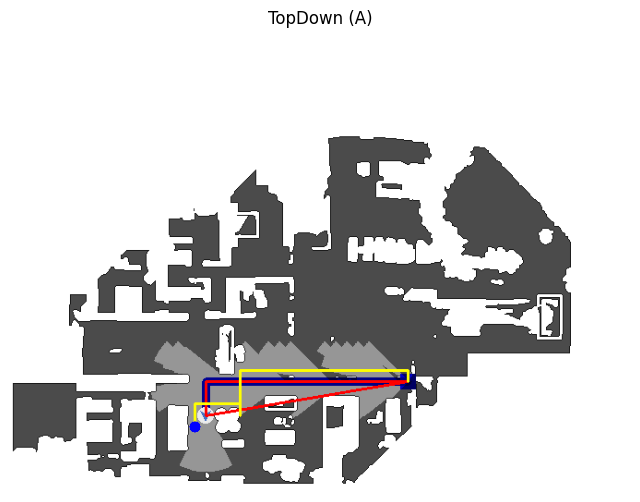

In [12]:
def npz_to_info_topdown(d):
    xy = d["agent_map_coord"]
    return {
        "top_down_map": {
            "map": d["map"],
            "fog_of_war_mask": d["fog_of_war_mask"],
            "agent_map_coord": (int(xy[0]), int(xy[1])),
            "agent_angle": float(d["agent_angle"]),
        }
    }

# 官方底图（来自 A 的第一帧）
info0 = npz_to_info_topdown(d0)
img_rgb = plot_top_down_map(info0, dataset="mp3d")  # RGB
img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

# 画 A（红）
for i in range(1, len(pathA_rc)):
    r1, c1 = pathA_rc[i-1]
    r2, c2 = pathA_rc[i]
    cv2.line(img_bgr, (c1, r1), (c2, r2), (0, 0, 255), 2)

# 画 B（黄）
for i in range(1, len(pathB_rc)):
    r1, c1 = pathB_rc[i-1]
    r2, c2 = pathB_rc[i]
    cv2.line(img_bgr, (c1, r1), (c2, r2), (0, 255, 255), 2)

# 起终点：A 绿/蓝，B 浅绿/青
r0, c0 = pathA_rc[0]; r1, c1 = pathA_rc[-1]
# cv2.circle(img_bgr, (c0, r0), 6, (0, 255, 0), -1)
# cv2.circle(img_bgr, (c1, r1), 6, (255, 0, 0), -1)

r0, c0 = pathB_rc[0]; r1, c1 = pathB_rc[-1]
# cv2.circle(img_bgr, (c0, r0), 6, (0, 200, 0), -1)
cv2.circle(img_bgr, (c1, r1), 6, (255, 0, 0), -1)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("TopDown (A)")


In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

from ss_baselines.common.utils import plot_top_down_map
# 9310,11302, 815
num =815
# ====== 你只要改这里 ======
A_DIR = f"/home/Disk/yyz/sound-spaces/vis/debug_npz/fzynW3qQPVF_{num}"

OTHER_DIRS = [
    f"/home/Disk/yyz/sound-spaces/vis/debug_npz_ours/fzynW3qQPVF_{num}",
    f"/home/Disk/yyz/sound-spaces/vis/debug_npz_iros/fzynW3qQPVF_{num}",
    f"/home/Disk/yyz/sound-spaces/vis/debug_npz_ral/fzynW3qQPVF_{num}",
]


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
2026-01-22 20:53:36.475605: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-22 20:53:36.708282: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-22 20:53:37.78

In [2]:
def sorted_npz_files(d):
    files = glob.glob(os.path.join(d, "*.npz"))
    assert len(files) > 0, f"No npz in {d}"
    # 适配你的 0.0.npz, 1.0.npz...
    return sorted(files, key=lambda p: float(os.path.basename(p).replace(".npz","")))

def npz_to_info_topdown(d):
    xy = d["agent_map_coord"]
    return {
        "top_down_map": {
            "map": d["map"],
            "fog_of_war_mask": d["fog_of_war_mask"],
            "agent_map_coord": (int(xy[0]), int(xy[1])),
            "agent_angle": float(d["agent_angle"]),
        }
    }

def world_to_grid_rc(world_xz, bounds, H, W, flip_z=False):
    (minx, _, minz), (maxx, _, maxz) = bounds
    x = world_xz[:, 0]
    z = world_xz[:, 1]
    c = (x - minx) / (maxx - minx + 1e-9) * (W - 1)
    if flip_z:
        r = (maxz - z) / (maxz - minz + 1e-9) * (H - 1)
    else:
        r = (z - minz) / (maxz - minz + 1e-9) * (H - 1)
    return np.stack([r, c], axis=1)  # (row,col)

def clip_rc(rc, H, W):
    r = np.clip(np.round(rc[:, 0]).astype(np.int32), 0, H - 1)
    c = np.clip(np.round(rc[:, 1]).astype(np.int32), 0, W - 1)
    return np.stack([r, c], axis=1)

def pick_best_flip(worldA, rcA, bounds, H, W):
    pred0 = world_to_grid_rc(worldA, bounds, H, W, flip_z=False)
    pred1 = world_to_grid_rc(worldA, bounds, H, W, flip_z=True)
    e0 = np.mean(np.linalg.norm(pred0 - rcA, axis=1))
    e1 = np.mean(np.linalg.norm(pred1 - rcA, axis=1))
    flip = (e1 < e0)
    print(f"Mean pixel error no-flip={e0:.3f}, flip_z={e1:.3f} -> use flip_z={flip}")
    return flip

def load_world(files, key_candidates=("agent_pos", "agent_world_pos")):
    world = []
    for f in files:
        d = np.load(f)
        k = None
        for cand in key_candidates:
            if cand in d:
                k = cand
                break
        assert k is not None, f"{os.path.basename(f)} has no agent_pos/agent_world_pos"
        world.append(d[k].astype(np.float32))
    return np.stack(world)

def load_A_world_and_rc(filesA):
    world = []
    rc = []
    for f in filesA:
        d = np.load(f)
        world.append(d["agent_pos"].astype(np.float32))         # (x,z)
        rc.append(d["agent_map_coord"].astype(np.float32))      # (row,col)
    return np.stack(world), np.stack(rc)


In [3]:
filesA = sorted_npz_files(A_DIR)
d0 = np.load(filesA[0])

bounds = d0["bounds"].astype(np.float32)  # (2,3)
H, W = map(int, d0["map_shape"])

# A 用于选择 flip_z
worldA, rcA = load_A_world_and_rc(filesA)
worldA , rcA = worldA[1:], rcA[1:]
flip_z = pick_best_flip(worldA, rcA, bounds, H, W)

# 官方底图
info0 = npz_to_info_topdown(d0)
img_rgb = plot_top_down_map(info0, dataset="mp3d")  # RGB
img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

print("Map shape (H,W):", H, W)


Mean pixel error no-flip=8.785, flip_z=271.694 -> use flip_z=False
Map shape (H,W): 499 672


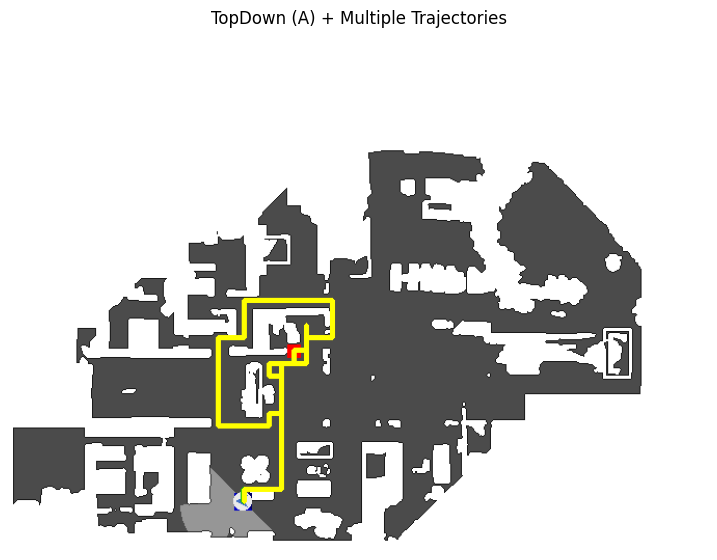

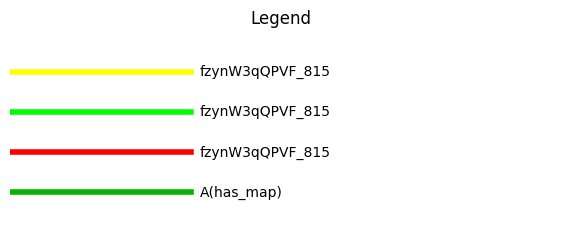

In [4]:
def draw_square(img, center_xy, size, color, thickness=-1):
    """
    center_xy: (x, y)
    size: 边长的一半（像素）
    thickness: -1 表示填充
    """
    x, y = center_xy
    pt1 = (int(x - size), int(y - size))
    pt2 = (int(x + size), int(y + size))
    cv2.rectangle(img, pt1, pt2, color, thickness)
# 颜色列表（BGR），不够用就循环
COLORS = [
    (0, 180, 0),
    (0, 0, 255),     # blue
    (0,255, 0, ),     # red
    (0, 255, 255),   # yellow
    (255, 0, 255),   # magenta
    (255, 255, 0),   # cyan
    (0, 128, 255),   # orange-ish
    (128, 0, 255),   # purple-ish
]

# --- 先画 A（用它自己的 rc 更稳） ---
pathA_rc = clip_rc(rcA, H, W)
colA = COLORS[0]

for i in range(1, len(pathA_rc)):
    r1, c1 = pathA_rc[i-1]
    r2, c2 = pathA_rc[i]
    cv2.line(img_bgr, (c1, r1), (c2, r2), colA, 4)

# A 起终点
r0, c0 = pathA_rc[0]; r1, c1 = pathA_rc[-1]
# cv2.circle(img_bgr, (c0, r0), 6, (0,255,0), -1)   # start green
draw_square(img_bgr, (c1, r1), size=6, color=(0, 0, 255), thickness=-1)

legend_items = [("A(has_map)", colA)]

# # --- 再画其它 dirs（world-only） ---
for idx, ddir in enumerate(OTHER_DIRS, start=1):
    files = sorted_npz_files(ddir)
    world = load_world(files)  # (x,z)

    rc = world_to_grid_rc(world, bounds, H, W, flip_z=flip_z)

    # rc = rc[:19]
    path_rc = clip_rc(rc, H, W)

    color = COLORS[idx % len(COLORS)]

    for i in range(1, len(path_rc)):
        r1, c1 = path_rc[i-1]
        r2, c2 = path_rc[i]
        cv2.line(img_bgr, (c1, r1), (c2, r2), color, 4)

    # 起终点小一点，避免遮挡
    r0, c0 = path_rc[0]; r1, c1 = path_rc[-1]
    # cv2.circle(img_bgr, (c0, r0), 4, color, -1)
    # cv2.circle(img_bgr, (c1, r1), 4, color, 1)

    legend_items.append((os.path.basename(ddir), color))

# --- 显示 ---
plt.figure(figsize=(9,9))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("TopDown (A) + Multiple Trajectories")
plt.savefig(
    f"/media/kemove/data/av_nav/notebook/debug_png/map/{num}_ours.png",
    dpi=300,              # 高分辨率（论文推荐）
    bbox_inches="tight",  # 去掉多余白边
    pad_inches=0.05,
    transparent=True      # 如果你想叠加到 PPT / LaTeX
)
plt.show()

# --- 画一个简单 legend（matplotlib） ---
plt.figure(figsize=(7, 1.2 + 0.35*len(legend_items)))
for i, (name, bgr) in enumerate(legend_items):
    rgb = (bgr[2]/255.0, bgr[1]/255.0, bgr[0]/255.0)
    plt.plot([0, 1], [i, i], color=rgb, linewidth=4)
    plt.text(1.05, i, name, va="center", fontsize=10)
plt.xlim(0, 3)
plt.ylim(-1, len(legend_items))
plt.axis("off")
plt.title("Legend")

plt.show()


In [84]:
world

array([[11.330067,  9.308961],
       [11.330067,  8.308961],
       [11.330067,  8.308961],
       [12.330067,  8.308961],
       [13.330067,  8.308961],
       [13.330067,  8.308961],
       [14.330067,  8.308961],
       [14.330067,  7.308961],
       [14.330067,  6.308961],
       [14.330067,  5.308961],
       [14.330067,  4.308961],
       [14.330067,  3.308961],
       [14.330067,  2.308961],
       [14.330067,  1.308961],
       [14.330067,  0.308961],
       [14.330067, -0.691039],
       [14.330067, -1.691039],
       [15.330067, -2.691039]], dtype=float32)